In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from sklearn.manifold import TSNE
import numpy as np

c:\msc_project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
G = nx.Graph()

In [3]:
# read the data file and convert it to a dictionary
# dictionary = {testcase ID (int): {"testcase": testcase name, "exec_line": list of executed lines}}
D = dict()
key_count = 0
previous_test_case = ''
with open('dataset/assertj-core1.txt') as f:
    for line in f:
        l_line = line.rstrip().split("\t")
        if previous_test_case != l_line[1]:
            previous_test_case = l_line[1]
            key_count += 1
        if key_count in D:
            D[key_count]["exec_line"].append(l_line[2]+l_line[3])
        else:
            D[key_count] = {"testcase": l_line[1], "exec_line":[l_line[2]+l_line[3]]}



In [4]:
# Create a graph
# networkx's document is refered.
# https://networkx.org/documentation/stable/tutorial.html

# add nodes
for i in D:
    # print(i)
    # print(D[i]["testcase"])
    G.add_node(i)

# add weighted edge: the number of common executed lines is the weight of edge.
for i in range(1, len(D)+1):
    for j in range(i+1, len(D)+1):
        weight = len(set(D[i]["exec_line"]) & set(D[j]["exec_line"]))
        if weight != 0:
            G.add_weighted_edges_from([(i,j,weight)])

edges = G.edges(data=True)
weight_set = ()

# draw the graph with colored edges according to the weight.
# the code "edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())"
# refers to : https://www.tutorialspoint.com/colouring-the-edges-by-weight-in-networkx-matplotlib
# print(nx.get_edge_attributes(G, 'weight').items())
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
# nx.draw_networkx(G,width=2, edge_color=weights, edge_cmap=plt.cm.Greys)
               
               
    

Computing transition probabilities:   0%|          | 0/1219 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [11:15<00:00, 67.51s/it]


[[ 3.3121815  1.8876828]
 [ 3.4833412  1.9266541]
 [ 2.9259272  2.4122362]
 ...
 [ 0.9503734 -6.513671 ]
 [-5.5419836  1.3172735]
 [-1.1320063 -3.4444864]]


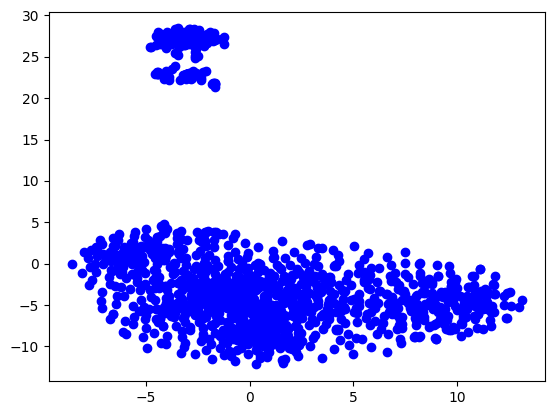

In [5]:
# Create Embedding
# https://github.com/eliorc/node2vec
# for destination in G.neighbors(1):
#     print(destination)
#     if G[1][destination].get("weight"):
#         weight = G[1][destination].get("weight", 1)
#         print("weight between 1 and destination is:", weight)
        
node2vec = Node2Vec(G, dimensions=128)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
# print(len(model.wv))
# for i in range(0,23):
#     print(model.wv[i])
embeddings = np.array([model.wv[x-1] for x in G.nodes])

# reduce the dimension using t-SNE
tsne = TSNE(n_components=2, random_state=7, perplexity=15)
embeddings_2d = tsne.fit_transform(embeddings)
print(embeddings_2d)
# visualise the embeddings
# plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
# plt.show()

for i in range(len(embeddings_2d)):
    x = embeddings_2d[i][0]
    y = embeddings_2d[i][1]
    plt.plot(x, y, 'bo')
    # plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)

plt.show()

First attempt (20th Jun): The last part of node2vec took time 84m 19.8s

Details:

Computing transition probabilities:   0%|          | 0/1219 [00:00<?, ?it/s]

Computing transition probabilities: 100%|██████████| 1219/1219 [1:12:15<00:00,  3.56s/it]

Generating walks (CPU: 1): 100%|██████████| 10/10 [11:15<00:00, 67.51s/it]

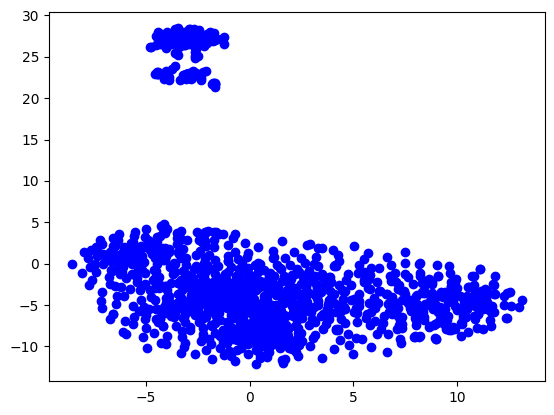

https://github.com/eliorc/node2vec/releases -> Gensim4.0 has changed its interface. node2vec solves this however anaconda supports only old version.

https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py -> Possible helpful tutorials for word2vec 